In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncode

In [2]:
#Naive Bayes Classifier Class
class NaiveBayes:    
    def prior(self, X, y):
        # calculate prior probability P(y)
        self.prior = (X.groupby(y).apply(lambda x: len(x)) / self.rows).to_numpy()
        return self.prior
    
    def stats(self, X, y):
        #calculate mean, variance for each column and convert to numpy array
        self.mu = X.groupby(y).apply(np.mean).to_numpy()
        self.sigma = X.groupby(y).apply(np.var).to_numpy()              
        return self.mu, self.sigma
    
    def density(self, i, x):     
        #calculate probability from gaussian density function (normally distributed)
        mu = self.mu[i]
        sigma = self.sigma[i]
        n = np.exp((-1 / 2) * ((x - mu) ** 2) / (2 * sigma))
        d = np.sqrt(2 * np.pi * sigma)
        p = n / d
        return p
    
    def posterior(self, x):
        posteriors = []
        # calculate posterior probability for each class
        for i in range(self.count):
            prior = np.log(self.prior[i]) ## use the log to make it more numerically stable
            conditional = np.sum(np.log(self.density(i, x))) # use the log to make it more numerically stable
            posterior = prior + conditional
            posteriors.append(posterior)
        # return class with highest posterior probability
        return self.classes[np.argmax(posteriors)]     

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.count = len(self.classes)
        self.feature_nums = X.shape[1]
        self.rows = X.shape[0]
        
        self.stats(X, y)
        self.prior(X, y)
        
    def predict(self, X):
        preds = [self.posterior(f) for f in X.to_numpy()]
        return preds

In [25]:
class LogisticRegression:
    def __init__(self, learning_rate = 0.01, epoch = 100000, fit_intercept = True, lam = 0.1, b = 0.5, func = "grad", isprint = False):
        self.learning_rate = learning_rate
        self.epoch = epoch
        self.fit_intercept = fit_intercept
        self.lam = lam
        self.b = b
        self.isprint = isprint
        self.func = func
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def loss(self, y_h, y):
        y = np.squeeze(np.asarray(y))
        y_h = np.squeeze(np.asarray(y_h))
        if self.func == "grad":
            return -np.mean(y * np.log(y_h) + (1.0001 - y) * (np.log(1.0001 - y_h)))
        elif self.func == "l1":
            return -np.mean(y * np.log(y_h) + (1.0001 - y) * (np.log(1.0001 - y_h))) + (self.lam * (np.sum(self.theta)))
        else:
            return -np.mean(y * np.log(y_h) + (1.0001 - y) * (np.log(1.0001 - y_h))) + (self.lam * (np.sum(np.square(self.theta))))
    
    def add_intercept(self, X):
        i = np.ones((X.shape[0], 1))
        return np.concatenate((i, X), axis=1)
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.add_intercept(X)            
        self.theta = np.zeros((X.shape[1], 1))
        self.b = np.zeros((len(y), 1))
        
        for i in range(self.epoch):
            if self.func == "grad":
                z = np.dot(X, self.theta)
                y_h = self.sigmoid(z)
                gradient = np.dot(X.T, (y_h - y)) / len(y)                
            else:
                z = np.dot(X, self.theta)
                y_h = self.sigmoid(z)
                if self.func == "l1":
                    gradient = np.dot(X.T, (y_h - y)) / len(y) + self.lam
                else:
                    gradient = np.dot(X.T, (y_h - y)) / len(y) + self.lam * self.theta            
            self.theta = self.theta - (self.learning_rate * gradient)          
            self.b = self.b - (self.learning_rate * np.sum(y_h - y))
            loss = self.loss(y_h, y)
            
            if(self.isprint == True and i % self.epoch == 0):
                print(self.func, "Loss:", loss)
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.add_intercept(X)    
        return self.sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        return self.predict_prob(X).round()

In [13]:
def split_accuracies(s, e, a, X, y):
    lrgs, lrl1s, lrl2s, nbs = [], [], [], []
    for i in range(s, e, a):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (100-i)/100, random_state = 0)
        y_train1 = np.asmatrix(y_train).T
        y_test1 = np.asmatrix(y_test).T
        lrg = LogisticRegression(learning_rate=0.0001, epoch=10000,func="grad")
        lrl1 = LogisticRegression(learning_rate=0.0001, epoch=10000,func="l1")
        lrl2 = LogisticRegression(learning_rate=0.0001, epoch=10000,func="l2")
        nb = NaiveBayes()
        nb.fit(X_train, y_train)
        lrg.fit(X_train, y_train1)
        lrl1.fit(X_train, y_train1)
        lrl2.fit(X_train, y_train1)
        pnb = nb.predict(X_test)
        plrg = lrg.predict(X_test)
        plrl1 = lrl1.predict(X_test)
        plrl2 = lrl2.predict(X_test)
        anb = accuracy_score(y_test, pnb)
        alrg = accuracy_score(y_test, plrg)
        alrl1 = accuracy_score(y_test, plrl1)
        alrl2 = accuracy_score(y_test, plrl2)
        nbs.append(anb)
        lrgs.append(alrg)
        lrl1s.append(alrl1)
        lrl2s.append(alrl2)
    return lrgs, lrl1s, lrl2s, nbs

In [14]:
df = pd.read_csv("data/mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [15]:
df.isna().any()

class                       False
cap-shape                   False
cap-surface                 False
cap-color                   False
bruises                     False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-root                  False
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                   False
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
dtype: bool

e    4208
p    3916
Name: class, dtype: int64


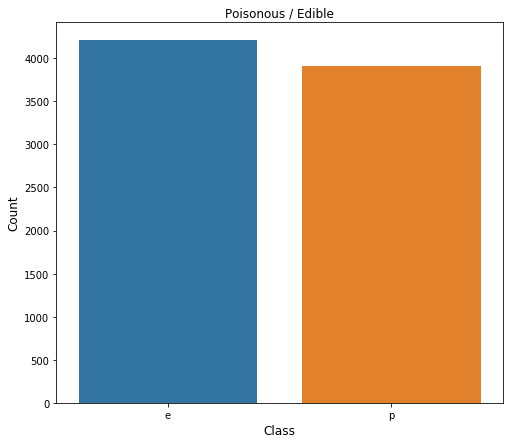

In [16]:
print(df['class'].value_counts())
count = df['class'].value_counts()
plt.figure(figsize=(8,7))
sns.barplot(count.index, count.values)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.title('Poisonous / Edible')
plt.show()

In [17]:
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
df = df.drop(["veil-type"],axis=1)
X = df.drop(['class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
y_train1 = np.asmatrix(y_train).T
y_test1 = np.asmatrix(y_test).T
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7311, 21) (7311,)
(813, 21) (813,)


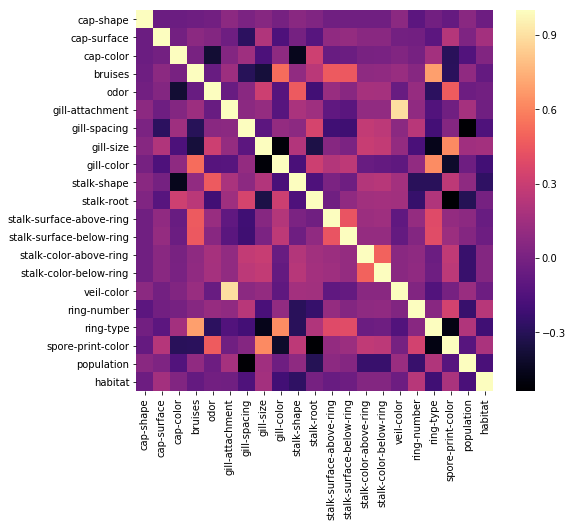

In [18]:
correlations = df.drop(columns=['class']).corr()
plt.figure(figsize=(8,7))
sns.heatmap(correlations,cmap='magma')
plt.show()

In [26]:
lrg = LogisticRegression(learning_rate=0.0001, epoch=10000,func="grad")
tlrg = %time lrg.fit(X_train, y_train1)
pg = lrg.predict(X_test)
print("Logistic Regression with Gradient Descent Classifier report: \n\n", classification_report(y_test1, pg))
lrl1 = LogisticRegression(learning_rate=0.0001, epoch=10000,func="l1")
tlrl1 = %time lrl1.fit(X_train, y_train1)
pl1 = lrl1.predict(X_test)
print("Logistic Regression with L1 regularization Classifier report: \n\n", classification_report(y_test1, pl1))
lrl2 = LogisticRegression(learning_rate=0.0001, epoch=10000,func="l2")
tlrl2 = %time lrl2.fit(X_train, y_train1)
pl2 = lrl2.predict(X_test)
print("Logistic Regression with L2 Regularization Classifier report: \n\n", classification_report(y_test1, pl2))
nb = NaiveBayes()
tnb = %time nb.fit(X_train, y_train)
pnb = nb.predict(X_test)
print("Naive Bayes Classifier report: \n\n", classification_report(y_test, pnb))

Wall time: 3.86 s
Logistic Regression with Gradient Descent Classifier report: 

               precision    recall  f1-score   support

           0       0.80      0.91      0.85       433
           1       0.87      0.74      0.80       380

   micro avg       0.83      0.83      0.83       813
   macro avg       0.84      0.83      0.83       813
weighted avg       0.84      0.83      0.83       813

Wall time: 4.06 s
Logistic Regression with L1 regularization Classifier report: 

               precision    recall  f1-score   support

           0       0.80      0.93      0.86       433
           1       0.90      0.73      0.81       380

   micro avg       0.84      0.84      0.84       813
   macro avg       0.85      0.83      0.83       813
weighted avg       0.85      0.84      0.83       813

Wall time: 3.91 s
Logistic Regression with L2 Regularization Classifier report: 

               precision    recall  f1-score   support

           0       0.80      0.91      0.85

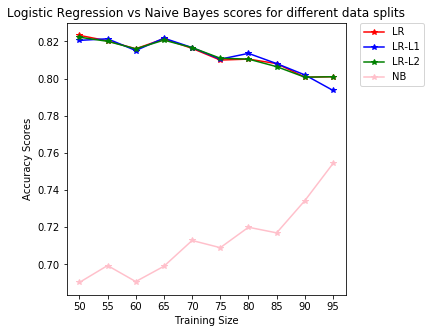

In [11]:
lrgs, lrl1s, lrl2s, nbs = split_accuracies(50, 100, 5, X, y)
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(50, 100,5)], lrgs, marker='*', color = 'red', label='LR')
plt.plot([i for i in range(50, 100,5)], lrl1s, marker='*', color = 'blue', label='LR-L1')
plt.plot([i for i in range(50, 100,5)], lrl2s, marker='*', color = 'green', label='LR-L2')
plt.plot([i for i in range(50, 100,5)], nbs, marker='*', color = 'pink', label='NB')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Training Size')
plt.xticks(np.arange(50,100,5))
plt.ylabel('Accuracy Scores')
plt.title('Logistic Regression vs Naive Bayes scores for different data splits')
plt.show()